# World CO2 Emissions Forecasting
## LSTM Model
[*Cristian Castro Álvarez*](https://github.com/cristian-castro-a)

**Goal**: 
- Forecast the amount of World CO2 emissions (in tonnes) for the next 10 years (2021 - 2030).


**Data:**
- The data comes from [Our World in Data](https://github.com/owid/co2-data)
- Column 'CO2' of the dataframe indicates the Tonnes of CO2 emmitted into the atmosphere.
- The dataset includes yearly data from 1750 to 2020, with a total of 271 data points.

In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import plotly.express as px
import math
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

# Data

In [2]:
df = pd.read_csv('../Data/owid-co2-data.csv')
df.head()

,iso_code,country,year,co2,co2_per_capita,trade_co2,cement_co2,cement_co2_per_capita,coal_co2,coal_co2_per_capita,...,ghg_excluding_lucf_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,0.002,NaN,NaN,NaN,0.015,0.002,...,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,0.011,NaN,NaN,NaN,0.021,0.003,...,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,0.012,NaN,NaN,NaN,0.026,0.003,...,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,0.012,NaN,NaN,NaN,0.032,0.004,...,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001732e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,0.013,NaN,NaN,NaN,0.038,0.005,...,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


In [3]:
# Aggregate the data on a yearly basis (the entire world as one entity, I don't care about the emissions of individual countries)
df = df.groupby(by=['year']).sum().reset_index()[['year','co2']]
df.insert(loc = 1, column = 'month', value = 12)
df.insert(loc = 2, column = 'day', value = 31)
values = pd.to_datetime(df[['year','month','day']])
df.insert(loc = 0, column = 'date', value = values)
df.drop(['year','month','day'], axis = 1, inplace = True)
df.head()

,date,co2
0,1750-12-31,46.755
1,1751-12-31,46.755
2,1752-12-31,46.770
3,1753-12-31,46.770
4,1754-12-31,46.790


In [4]:
# To work with tonnes of CO2 it is necessary a conversion factor of 3.664
df['co2'] = df['co2']/3.664
df.tail().round(1)

,date,co2
266,2016-12-31,34035.4
267,2017-12-31,34471.8
268,2018-12-31,35058.0
269,2019-12-31,35049.9
270,2020-12-31,33185.8


In [5]:
# Visualizing the yearly emissions
fig = px.line(df, 
                x = 'date', 
                y = 'co2', 
                markers = True, 
                height = 800, 
                width = 1000)

fig.update_layout(title = dict(
        text = 'Total World CO2 Emissions',
        font = dict(
            family = 'Arial',
            size = 30
        ),
        x = 0.5
    )
    )

fig.update_traces(line_color = 'darkblue')

fig.update_xaxes(
    title_text = 'Date',
    title_font = {'size': 20}
)

fig.update_yaxes(
    title_text = 'Million Tonnes of CO2 Emmitted into the Atmosphere',
    title_font = {'size': 20}
)

fig.show()

## Windowing Function

In [6]:
def df_to_inputs(df, window_size = 5):
    # Input: dataframe with the time series and window size
    # Windows size refers to the number of points in the series with which the model will be trained
    # Output: X, y for training
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        X.append([[a] for a in df_as_np[i:i+5]])
        y.append(df_as_np[i+5])
    return np.array(X), np.array(y)

In [7]:
# Getting the windows
WINDOW_SIZE = 5
X, y = df_to_inputs(df['co2'], WINDOW_SIZE)

In [8]:
X.shape, y.shape

((266, 5, 1), (266,))

In [9]:
X[1:3]

array([[[12.7606441 ],
        [12.76473799],
        [12.76473799],
        [12.77019651],
        [12.77565502]],

       [[12.76473799],
        [12.76473799],
        [12.77019651],
        [12.77565502],
        [13.65447598]]])

## Scaling and Splitting for Train, Validation and Test Sets

In [10]:
# 85% Train, 7.5% Valid, 7.5% Test
print(f'80% of samples for Training: {math.ceil(0.85*266)} samples')
print(f'7.5% of samples for Validating: {math.ceil(0.075*266)} samples')
print(f'7.5% of samples for Testing: {math.ceil(0.075*266)} samples')

80% of samples for Training: 227 samples
7.5% of samples for Validating: 20 samples
7.5% of samples for Testing: 20 samples


In [11]:
# 85% Train, 7.5% Valid, 7.5% Test
# X_train, y_train = X[:227], y[:227]
# X_val, y_val = X[227:247], y[227:247]
# X_test, y_test = X[247:], y[247:]

df_train = df[:247].copy()
df_test = df[247:].copy()

In [12]:
# Scaling the Data
df_train_scaled = df_train
df_test_scaled = df_test

scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(df_train['co2'].values.reshape(-1,1))
df_train_scaled['co2'] = scaler.transform(df_train['co2'].values.reshape(-1,1))
df_test_scaled['co2'] = scaler.transform(df_test['co2'].values.reshape(-1,1))

In [13]:
# Windowing
WINDOW_SIZE = 5

X_train, y_train = df_to_inputs(df_train_scaled['co2'], WINDOW_SIZE)
X_test, y_test = df_to_inputs(df_test_scaled['co2'], WINDOW_SIZE)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((242, 5, 1), (242,), (19, 5, 1), (19,))

In [15]:
X_train[1:3]

array([[[0.00000000e+00],
        [1.66839395e-07],
        [1.66839395e-07],
        [3.89291923e-07],
        [6.11744450e-07]],

       [[1.66839395e-07],
        [1.66839395e-07],
        [3.89291923e-07],
        [6.11744450e-07],
        [3.64266013e-05]]])

In [16]:
X_train[1].shape

(5, 1)

## Building the LSTM Model

In [35]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(units = 100, return_sequences = False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 100)            40800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, batch_size = 1, epochs = 30)

Train on 242 samples
Epoch 1/30


2022-09-27 22:35:10.987931: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_12384_12853' and '__inference___backward_standard_lstm_12384_12853_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_12959' both implement 'lstm_77402ace-af2f-4322-86e0-769e7958394c' but their signatures do not match.


242/242 [==============================] - 8s 32ms/sample - loss: 0.0049
Epoch 2/30
242/242 [==============================] - 4s 17ms/sample - loss: 8.5678e-04
Epoch 3/30
242/242 [==============================] - 4s 17ms/sample - loss: 0.0027
Epoch 4/30
242/242 [==============================] - 4s 17ms/sample - loss: 8.1083e-04
Epoch 5/30
242/242 [==============================] - 4s 17ms/sample - loss: 0.0018
Epoch 6/30
242/242 [==============================] - 4s 17ms/sample - loss: 0.0015
Epoch 7/30
242/242 [==============================] - 4s 17ms/sample - loss: 0.0012
Epoch 8/30
242/242 [==============================] - 4s 17ms/sample - loss: 0.0013
Epoch 9/30
242/242 [==============================] - 4s 17ms/sample - loss: 5.0211e-04
Epoch 10/30
242/242 [==============================] - 4s 17ms/sample - loss: 6.7645e-04
Epoch 11/30
242/242 [==============================] - 4s 17ms/sample - loss: 9.1290e-04
Epoch 12/30
242/242 [==============================] - 4s 17ms/sa

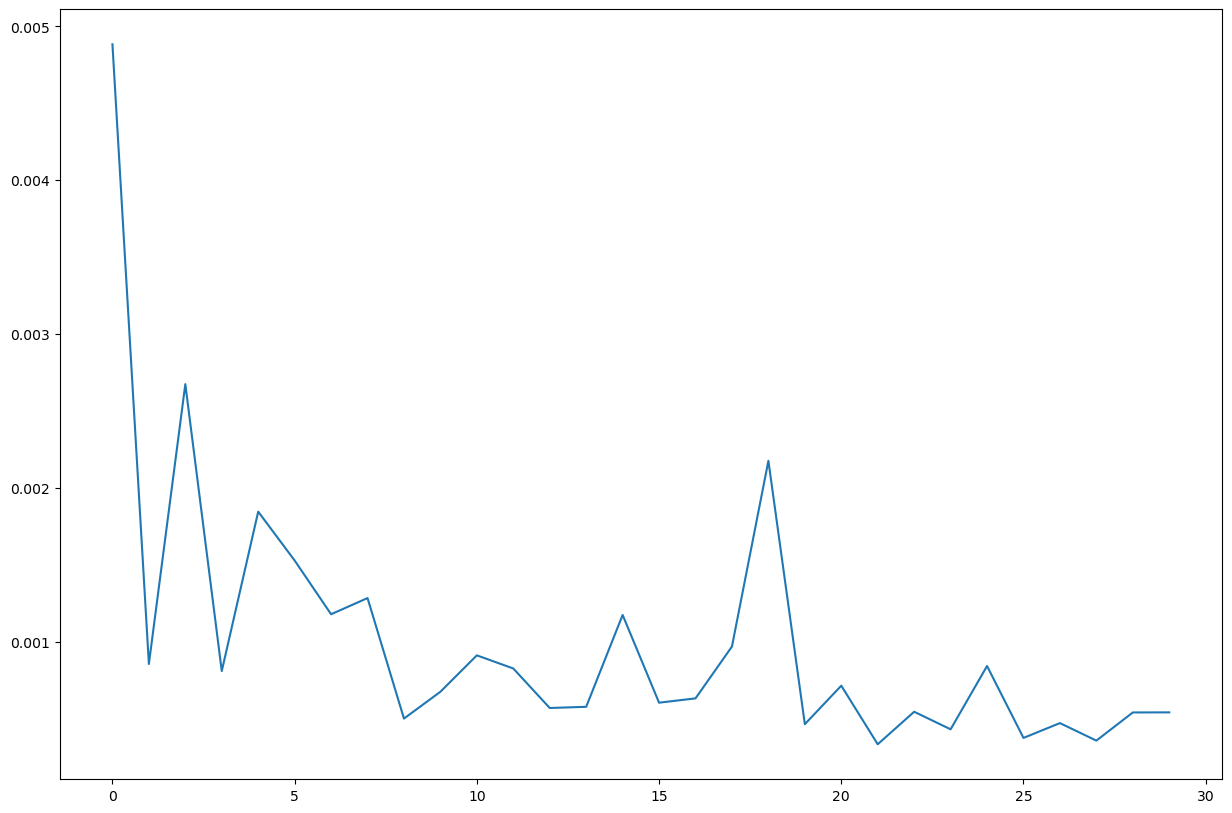

In [37]:
plt.plot(history.history['loss'])
plt.show()

## Predictions

In [38]:
# Predict and inverse the scaling
predicted = model.predict(X_test)
scaled_predicted = scaler.inverse_transform(predicted)
scaled_predicted

2022-09-27 22:37:47.848928: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_27714_specialized_for_sequential_1_lstm_2_StatefulPartitionedCall_at___inference_distributed_function_28491' and '__inference_standard_lstm_27714' both implement 'lstm_352eea8d-876e-42a8-9fb0-9a96821bffe0' but their signatures do not match.


array([[26597.787],
       [26882.824],
       [27414.484],
       [28047.184],
       [28671.975],
       [29351.69 ],
       [30016.865],
       [30545.998],
       [30757.88 ],
       [31237.014],
       [31682.053],
       [32068.607],
       [32381.8  ],
       [32727.14 ],
       [32895.184],
       [32964.445],
       [33071.77 ],
       [33242.41 ],
       [33358.12 ]], dtype=float32)

In [39]:
df_pred = df[252:]
df_pred['co2'] = scaled_predicted
df_pred

,date,co2
252,2002-12-31,26597.787109
253,2003-12-31,26882.824219
254,2004-12-31,27414.484375
255,2005-12-31,28047.183594
256,2006-12-31,28671.974609
257,2007-12-31,29351.689453
258,2008-12-31,30016.865234
259,2009-12-31,30545.998047
260,2010-12-31,30757.880859
261,2011-12-31,31237.013672


In [34]:
## Plotting the Results
# Visualizing the yearly emissions
fig = px.line(df, 
                x = 'date', 
                y = 'co2', 
                markers = True,
                height = 800, 
                width = 1000)

fig.update_layout(title = dict(
        text = 'Total World CO2 Emissions',
        font = dict(
            family = 'Arial',
            size = 30
        ),
        x = 0.5
    )
    )

fig.update_traces(line_color = 'darkblue')

fig.update_xaxes(
    title_text = 'Date',
    title_font = {'size': 20}
)

fig.update_yaxes(
    title_text = 'Million Tonnes of CO2 Emmitted into the Atmosphere',
    title_font = {'size': 20}
)

fig.show()